## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
universe = pd.read_csv('factor_data/all_147_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe.head()

,ts_code,trade_date,name,industry,close,issue_price,log-ret,alpha_atr,alpha_pb,alpha_ppo,alpha_winlos,alpha_skew2sentiment,alpha_010,alpha_030,alpha_016,alpha_021,alpha_040,alpha_122,alpha_149,alpha_190
date,,,,,,,,,,,,,,,,,,,,
2020-05-06,000411.SZ,20200506,英特集团,医药商业,9.21252,16.01672,-0.000882,1.181910,0.408441,1.102746,0.795173,-0.014944,0.021971,1.181910,0.021835,0.022043,0.022029,0.021713,0.022525,0.021968
2020-05-06,603367.SH,20200506,辰欣药业,化学制药,15.26178,11.66000,0.033838,0.429857,1.261643,1.238517,0.013965,0.428793,0.014119,-0.817820,0.014025,0.014159,0.014151,0.013973,0.014436,0.014119
2020-05-06,002365.SZ,20200506,永安药业,化学制药,10.02945,31.00000,0.007804,1.261642,1.123012,1.603730,0.152596,-0.088864,0.014119,0.984381,0.014025,0.014159,0.014151,0.013973,0.014436,0.014119
2020-05-06,300723.SZ,20200506,一品红,化学制药,22.71169,17.05000,0.000243,-0.817820,-1.095082,-0.106455,0.845750,-0.267152,0.014119,1.538904,0.014025,0.014159,0.014151,0.013973,0.014436,0.014119
2020-05-06,603590.SH,20200506,康辰药业,化学制药,32.21381,24.34000,0.014202,-1.372343,0.845750,3.704194,-0.817820,0.558880,0.014119,0.291227,0.014025,0.014159,0.014151,0.013973,0.014436,0.014119


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [3]:
universe.industry.unique()

array(['医药商业', '化学制药', '生物制药', '中成药', '医疗保健'], dtype=object)

In [5]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4, '医疗保健':5}
all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,name,industry,close,issue_price,log-ret,alpha_atr,alpha_pb,alpha_ppo,...,alpha_021,alpha_040,alpha_122,alpha_149,alpha_190,sector_1,sector_2,sector_3,sector_4,sector_5
date,,,,,,,,,,,,,,,,,,,,,
2020-05-06,000411.SZ,20200506,英特集团,医药商业,9.21252,16.01672,-0.000882,1.181910,0.408441,1.102746,...,0.022043,0.022029,0.021713,0.022525,0.021968,False,True,False,False,False
2020-05-06,603367.SH,20200506,辰欣药业,化学制药,15.26178,11.66000,0.033838,0.429857,1.261643,1.238517,...,0.014159,0.014151,0.013973,0.014436,0.014119,True,False,False,False,False
2020-05-06,002365.SZ,20200506,永安药业,化学制药,10.02945,31.00000,0.007804,1.261642,1.123012,1.603730,...,0.014159,0.014151,0.013973,0.014436,0.014119,True,False,False,False,False
2020-05-06,300723.SZ,20200506,一品红,化学制药,22.71169,17.05000,0.000243,-0.817820,-1.095082,-0.106455,...,0.014159,0.014151,0.013973,0.014436,0.014119,True,False,False,False,False
2020-05-06,603590.SH,20200506,康辰药业,化学制药,32.21381,24.34000,0.014202,-1.372343,0.845750,3.704194,...,0.014159,0.014151,0.013973,0.014436,0.014119,True,False,False,False,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [6]:
quantile_jud = all_factors['log-ret'].quantile([0.33,0.66,1.])
quantile_jud

0.33   -0.009390
0.66    0.007264
1.00    0.182639
Name: log-ret, dtype: float64

In [7]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.01, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [8]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-5).fillna(0).astype(np.int16)

In [9]:
all_factors['target'].unique()

array([ 0, -1,  1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

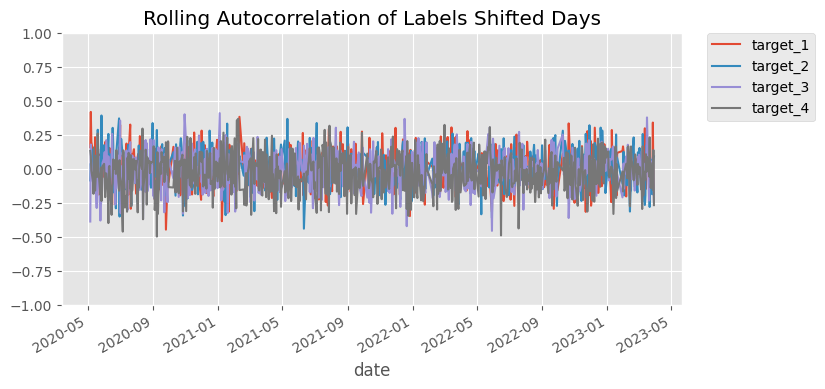

In [10]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220501]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [11]:
features = [
            'alpha_atr', 'alpha_pb', 'alpha_ppo', 'alpha_winlos', 'alpha_skew2sentiment',
            'alpha_010', 'alpha_030', 'alpha_016', 'alpha_021','alpha_040','alpha_122','alpha_149', 'alpha_190'
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(72224, 30)


In [12]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
print(all_factors.shape)
all_factors.head()

(71637, 30)


trade_date  name industry     close  issue_price  \
date       ts_code                                                       
2020-05-06 000411.SZ    20200506  英特集团     医药商业   9.21252     16.01672   
           300485.SZ    20200506  赛升药业     生物制药  15.04271     38.46000   
           300406.SZ    20200506  九强生物     生物制药  17.51101     14.32000   
           300294.SZ    20200506  博雅生物     生物制药  30.77025     25.00000   
           300791.SZ    20200506  仙乐健康     医疗保健  22.86701     54.73000   

                       log-ret  alpha_atr  alpha_pb  alpha_ppo  alpha_winlos  \
date       ts_code                                                             
2020-05-06 000411.SZ -0.000882   1.181910  0.408441   1.102746      0.795173   
           300485.SZ -0.009693  -1.088565  1.141532  -8.225787      0.893743   
           300406.SZ  0.029802   1.141531 -0.592988   0.575270     -1.336353   
           300294.SZ -0.002248  -0.592988  0.398166   1.636962     -0.345199   
           300791.SZ  0.012540   0.082937  1.028024  -0.013978     -0.862148   

                      ...  sector_2  sector_3  sector_4  sector_5  return_2q  \
date       ts_code    ...                                                      
2020-05-06 000411.SZ  ...      True     False     False     False          0   
           300485.SZ  ...     False     False      True     False          0   
           300406.SZ  ...     False     False      True     False          1   
           300294.SZ  ...     False     False      True     False          0   
           300791.SZ  ...     False     False     False      True          1   

                      target  target_1  target_2  target_3  target_4  
date       ts_code                                                    
2020-05-06 000411.SZ       0       0.0       0.0       0.0       0.0  
           300485.SZ       0      -1.0       1.0       1.0       1.0  
           300406.SZ       0       1.0       0.0      -1.0       1.0  
           300294.SZ      -1      -1.0       1.0       0.0       1.0  
           300791.SZ       1       1.0       1.0       1.0       0.0  

[5 rows x 30 columns]

In [13]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

X_valid.tail()

alpha_atr  alpha_pb  alpha_ppo  alpha_winlos  \
date       ts_code                                                   
2022-10-25 688338.SH   0.147559  0.858393  -1.505658      0.858392   
           300723.SZ  -0.945210 -1.413559  -2.647441      0.647171   
           301093.SZ   0.325267  1.213811   0.473034      1.480371   
           301234.SZ  -1.185254 -0.652130  -1.484858     -1.185254   
           605266.SH  -1.331879 -1.621949  -4.539149      0.988542   

                      alpha_skew2sentiment  alpha_010  alpha_030  alpha_016  \
date       ts_code                                                            
2022-10-25 688338.SH              0.684738  -0.656393   0.414122   0.682962   
           300723.SZ              0.654840  -1.145018  -0.195854   0.320689   
           301093.SZ              0.245559  -0.477523  -0.119004  -1.100070   
           301234.SZ             -3.374640  -1.014134  -1.451820  -1.545829   
           605266.SH              0.699261  -1.642210   0.698489  -1.632035   

                      alpha_021  alpha_040  alpha_122  alpha_149  alpha_190  \
date       ts_code                                                            
2022-10-25 688338.SH  -0.120008  -1.374014   0.058724  -1.529108  -1.551254   
           300723.SZ  -0.958303  -1.432345  -0.570852   0.572161  -1.523861   
           301093.SZ   0.955241   0.327904   0.769794   1.149664  -0.030357   
           301234.SZ  -0.568029   1.402800  -0.385695  -1.529108   1.311611   
           605266.SH  -1.647581  -0.763173  -1.042475  -1.081441  -1.348358   

                      sector_1  sector_2  sector_3  sector_4  sector_5  
date       ts_code                                                      
2022-10-25 688338.SH     False     False     False     False      True  
           300723.SZ      True     False     False     False     False  
           301093.SZ     False     False     False     False      True  
           301234.SZ     False     False     False     False      True  
           605266.SH     False      True     False     False     False

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [26]:
n_days = 50
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 2000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [20,50,80,100]

### Pick Important Features by Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 4/4 [00:05<00:00,  1.29s/Model]


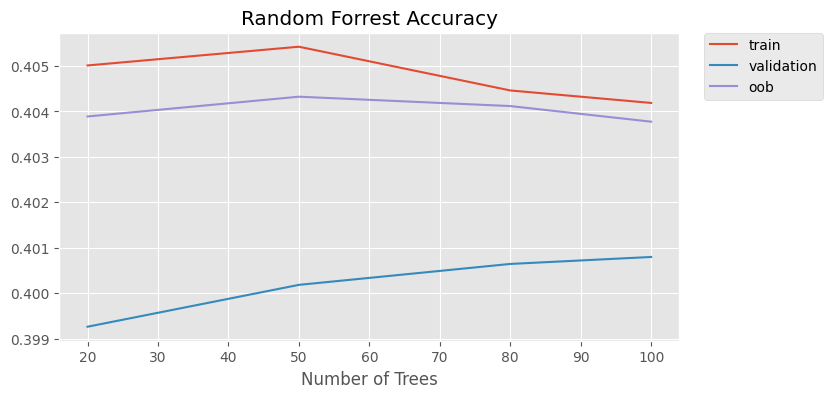

Features Ranked by Average Importance:

      Feature                  Importance
 1. alpha_atr            (0.26705767865979696)
 2. alpha_pb             (0.2208778306276448)
 3. alpha_ppo            (0.18446629457987307)
 4. alpha_149            (0.10034067344322613)
 5. alpha_winlos         (0.07256427295937373)
 6. alpha_122            (0.05525885216792364)
 7. alpha_016            (0.03999688325972845)
 8. alpha_030            (0.03581683808142251)
 9. alpha_021            (0.007015059441352032)
10. alpha_040            (0.006411222554437641)
11. alpha_010            (0.00497109076187901)
12. alpha_skew2sentiment (0.004660548190706224)
13. alpha_190            (0.0005627552726358209)
14. sector_4             (0.0)
15. sector_1             (0.0)
16. sector_2             (0.0)
17. sector_3             (0.0)
18. sector_5             (0.0)


In [28]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=3):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [38]:
n_days = 16
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 500,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [20, 40, 80, 100]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 4/4 [00:07<00:00,  1.95s/Model]


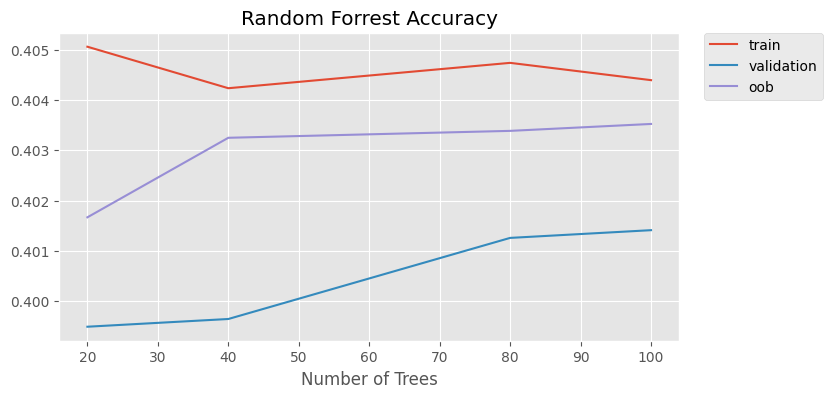

In [39]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.4014116924965475
Precision score:  0.4014116924965475
Recall score:  0.4014116924965475
F1 score:  0.4014116924965475


In [41]:
'''
 1. alpha_atr            (0.26705767865979696)
 2. alpha_pb             (0.2208778306276448)
 3. alpha_ppo            (0.18446629457987307)
 4. alpha_149            (0.10034067344322613)
 5. alpha_winlos         (0.07256427295937373)
'''

factor_names = [ 
            'alpha_atr', 'alpha_pb', 'alpha_ppo', 
            'alpha_winlos', 'alpha_skew2sentiment',
            'alpha_149', 'alpha_030', 'alpha_010', 'alpha_016'
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [42]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=5)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

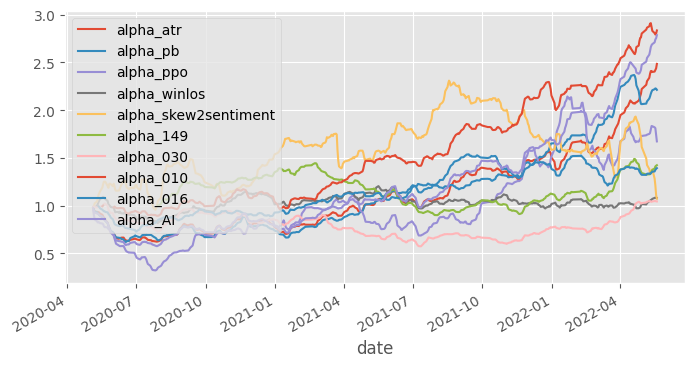

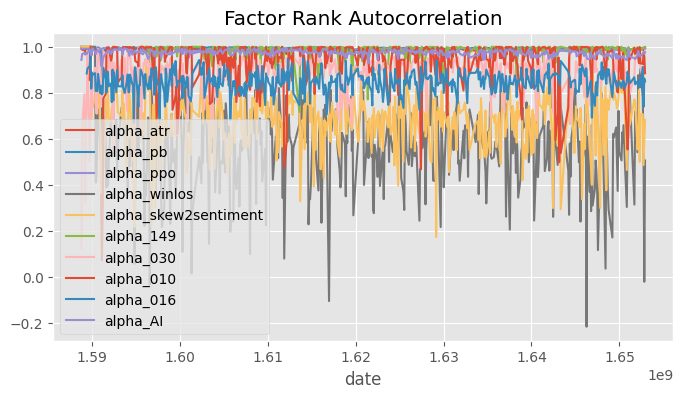

In [43]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

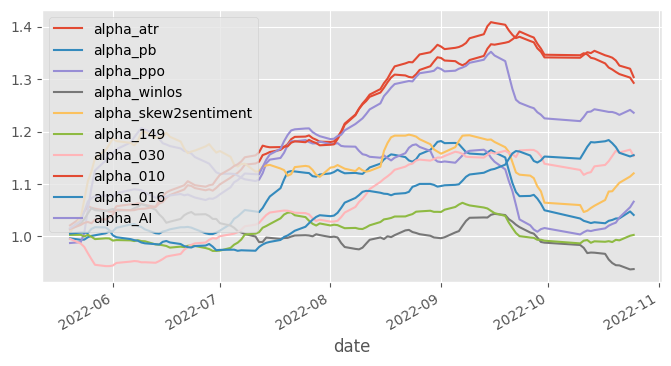

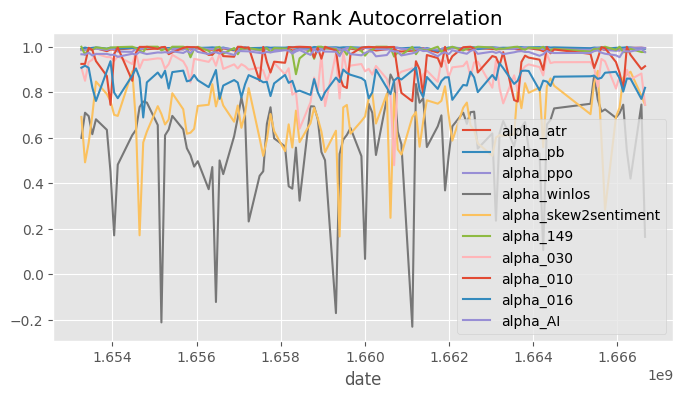

In [44]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [47]:
n_days = 16
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 1000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 100

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [48]:
print(train_score)
print(valid_score, oob_score)

[0.40485023358065403]
[0.4021789166794537] [0.40277243993043865]


### View Train Set Results

Cleaning Data...

Dropped 3.9% entries from factor data: 3.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 3.9% entries from factor data: 3.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 3.9% entries from factor data: 3.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 3.9% entries from factor data: 3.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 3.9% entries from factor data: 3.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

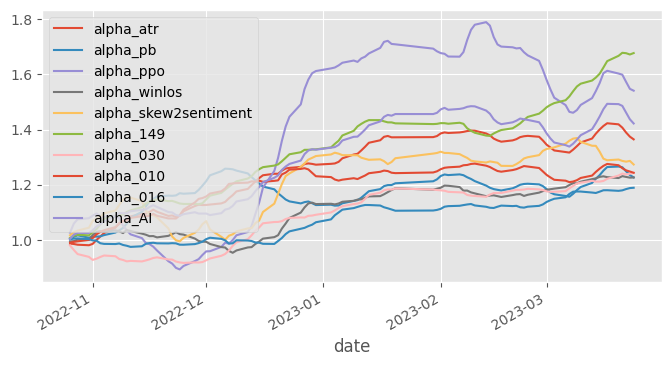

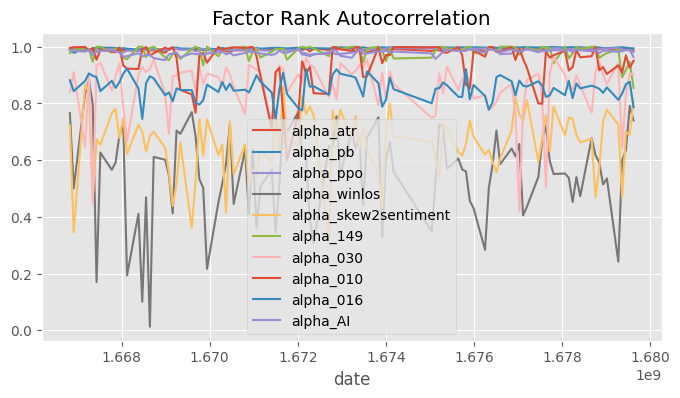

In [49]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 6.9% entries from factor data: 0.8% in forward returns computation and 6.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

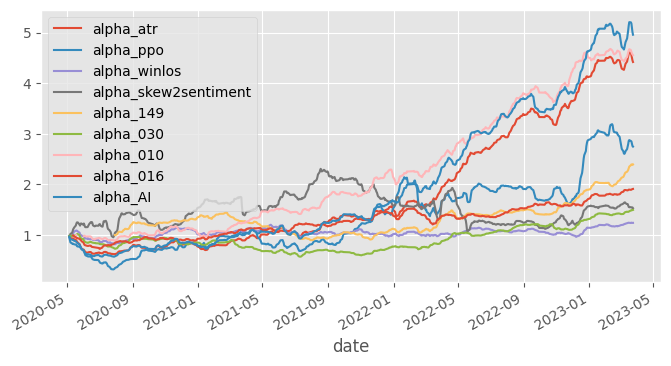

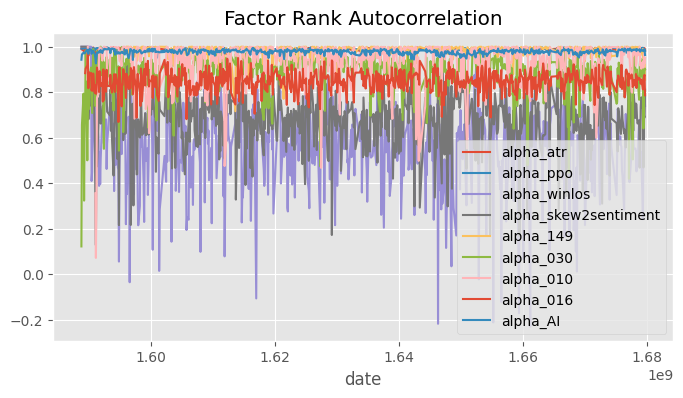

In [54]:
factor_names = [
                'alpha_atr',  'alpha_ppo', 
                'alpha_winlos', 'alpha_skew2sentiment',
                'alpha_149', 'alpha_030', 'alpha_010', 'alpha_016'
           ]
tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([tmp, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [55]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha
    
save_factors = save_AI_factors(all_factors, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.0066859  -0.03406053 -0.02324059 ... -0.02069222 -0.02177875
 -0.04035922] 71637


In [56]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr', 'alpha_010', 'alpha_149', 'alpha_AI'
        ]
save_factors[field].to_csv('factors_AI_147.csv')

### Save RandomForest Model

In [57]:
import joblib

joblib.dump(clf_nov, 'clf_147.pkl')


['clf_147.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))